# Lab04 - Evaluation

In [212]:
# Import
import pickle
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

In [200]:
# Export
export_path = "./export/"

In [217]:
# Utils
def save_latex_table(table, name):
    file_path = export_path + "table_"+ name +".tex"
    with open(file_path, "w") as text_file:
        text_file.write(table.to_latex(index=False))
        print "-> " + file_path + " saved!"
        print "\n"
        
def save_pickle(obj, name):
    file_path = export_path + name +".pickle"
    with open(file_path, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print "-> " + file_path + " saved!"
        print "\n"
    
def load_pickle(name):
    file_path = export_path + name +".pickle"
    with open(file_path, 'rb') as handle:
        obj = pickle.load(handle)
        print "-> " + file_path + " loaded!"
        print "\n"
        return obj


## Collection loading

In [202]:
coll = pd.read_table("../app/asset/cacm_v2.txt", delimiter="\t", names=["doc_id", "author", "summary", "etc"])
coll.head()

,doc_id,author,summary,etc
0,1,"Perlis, A. J.;Samelson,K.;",Preliminary Report-International Algebraic Lan...,NaN
1,2,"Sugai, I.;",Extraction of Roots by Repeated Subtractions f...,NaN
2,3,"Friedman, M. D.;",Techniques Department on Matrix Program Schemes,NaN
3,4,NaN,Glossary of Computer Engineering and Programmi...,NaN
4,5,"Wadey, W. G.;",Two Square-Root Approximations,NaN


## Query results loading

In [203]:
# True query results
qrels = pd.read_table("../app/asset/qrels.txt", delimiter=" ", names=["query_id", "query_res"])
qrels["relevant"] = True
qrels.head()

,query_id,query_res,relevant
0,1,1410,True
1,1,1572,True
2,1,1605,True
3,1,2020,True
4,1,2358,True


In [204]:
# Query results with the different analyzers
names = ["query_id", "query_res"]
delimiter = " "

results = {
    "whitespace" : pd.read_table("../app/results/qrels_whitespace.txt", delimiter=delimiter, names=names),
    "standard" : pd.read_table("../app/results/qrels_standard.txt", delimiter=delimiter, names=names),
    "english" : pd.read_table("../app/results/qrels_english.txt", delimiter=delimiter, names=names),
    "english_custom" : pd.read_table("../app/results/qrels_english_custom.txt", delimiter=delimiter, names=names)
}

### 1. Summary statistics

#### Functions

In [205]:
def findRelevant(df):
    df["relevant"] = None
    for idx, row in df.iterrows():
        isRelevant = ((qrels['query_id'] == row.query_id) & 
                      (qrels['query_res'] == row.query_res)).any()
        df.set_value(idx, 'relevant', isRelevant)
    return df

#### Execution

In [206]:
summary = []
tmp = {}

for k, v in results.iteritems():
    row = []
    row.append(k)
    row.append(coll.shape[0]) # a. Total number of documents
    row.append(v.shape[0]) # b. total number retrieved documents for all queries
    row.append(qrels.shape[0]) # c. total number of relevant documents for all queries
    v = findRelevant(v)
    nbRelevant = v.loc[v['relevant'] == True].shape[0]
    row.append(nbRelevant) # d. total number of relevant documents retrieved for all queries
    summary.append(row)
    tmp[k]=v
    print row

['english', 3204, 82734, 796, 720]
['english_custom', 3204, 142419, 796, 766]
['whitespace', 3204, 121648, 796, 680]
['standard', 3204, 47211, 796, 620]


In [208]:
summary = pd.DataFrame(summary, columns=['Analyzer', 'a.', 'b.', 'c.', 'd.'])
summary

,Analyzer,a.,b.,c.,d.
0,english,3204,82734,796,720
1,english_custom,3204,142419,796,766
2,whitespace,3204,121648,796,680
3,standard,3204,47211,796,620


In [216]:
# Save the summary
summary.to_csv(export_path+"summary_statistics.csv")
save_latex_table(summary, "summary")

-> ./export/table_summary.tex saved!




In [220]:
# Save the processed results Dict
results = tmp
save_pickle(results, "results")

-> ./export/results.pickle saved!




## 2. Average Precision at Standard Recall Levels

http://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html

- Works but has a problem and does not take the non-relevant into account
- TODO Implement with all the analyzers

---
### Part 1 Compute the Precision and Recall values

#### Functions

In [210]:
def computeAveragePrecision(df):

    # Setup the empty columns
    df['precision'] = None
    df['recall'] = None
        
    # Loop everything
    for idx, row in df.iterrows():
        
        df_at_idx = df.head(idx+1)

        # Get true positive
        tp = df_at_idx.loc[df_at_idx['relevant'] == True].shape[0]

        # Get false positive
        fp = df_at_idx.loc[df_at_idx['relevant'] == False].shape[0]

        # Get false negative
        fn = qrels.loc[qrels.query_id == query_id].shape[0]-tp

        # Compute precision and recall
        if (tp+fp) != 0:
            precision = tp/(tp+fp)
        else:
            precision = "Div0"
        
        if tp+fn != 0:
            recall = tp/(tp+fn)
        else:
            recall = "Div0"

        df.set_value(idx, 'precision', precision)
        df.set_value(idx, 'recall', recall)
        
    return df

#### Execution

In [234]:
# Load the results
results = load_pickle("results")

-> ./export/results.pickle loaded!




In [239]:
results["standard"].head()

,query_id,query_res,relevant
0,1,2319,False
1,1,1938,False
2,1,1410,True
3,1,1519,False
4,1,2629,False


In [236]:
# TODO Remove when code is working
print "Try with only one Analyzer"
print "keys before : " 
print results.keys()
results = {"standard" : results["standard"]}
print "keys after : "
print results.keys()

Try with only one Analyzer
keys before : 
['english', 'english_custom', 'whitespace', 'standard']
keys after : 
['standard']


In [240]:
# Compute precision and recall for each analyzer
for k, result in results.iteritems():
    
    print k
    average_precision_df = pd.DataFrame()  
    
    # Run for each query
    for query_id in range(result.query_id.unique().shape[0]):
        
        # Setup dataframe
        df = result.loc[result['query_id'] == query_id]
        df.reset_index(inplace=True)
        
        # Compute
        df = computeAveragePrecision(df)
        
        # Aggregate results
        average_precision_df = average_precision_df.append(df)
    
    results[k] = average_precision_df

standard


/Users/fredmontet/.pyenv/versions/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fredmontet/.pyenv/versions/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [241]:
results["standard"].head()

,index,query_id,query_res,relevant,precision,recall
0,0,1,2319,False,0,0
1,1,1,1938,False,0,0
2,2,1,1410,True,0.333333,0.2
3,3,1,1519,False,0.25,0.2
4,4,1,2629,False,0.2,0.2


In [247]:
save_pickle(results, "results_2_1")

-> ./export/results_2_1.pickle saved!




---
### Part 2 Interpolate

#### Functions

In [262]:
def interpolate(qdf):
    
    # Setup 
    arr = []
    df = qdf[["precision", "recall"]]
    i_max = df.shape[0]-1

    # Init values
    r_i_tmp = 0
    p_0 = 0
    r_0 = 0
    p_1 = 0
    r_1 = 0

    # Loop
    i = 0
    while i <= i_max:

        # all the point except first and last
        if i > 0 and i < i_max-1:

            if (df.precision[i] > df.precision[i+1] and df.precision[i] > df.precision[i-1]):

                p_0 = df.precision[i]
                r_0 = df.recall[r_i_tmp]
                p_1 = df.precision[i]
                r_1 = df.recall[i]

                r_i_tmp = i

                arr.append([p_0, r_0])
                arr.append([p_1, r_1])
        i+=1
    
    return arr

#### Execute

In [249]:
# Load data
results = load_pickle("results_2_1")

-> ./export/results_2_1.pickle loaded!




In [263]:
results.keys()

['standard']

In [264]:
results["standard"].head()

,index,query_id,query_res,relevant,precision,recall
0,0,1,2319,False,0,0
1,1,1,1938,False,0,0
2,2,1,1410,True,0.333333,0.2
3,3,1,1519,False,0.25,0.2
4,4,1,2629,False,0.2,0.2


In [270]:
interpolated = {}

In [283]:
# Interpolate for each analyzer
for k, result in results.iteritems():
    
    print k
    ai = []  
    
    # Run for each query
    for query_id in range(result.query_id.unique().shape[0]):
        
        # Setup dataframe
        df = result.loc[result['query_id'] == query_id]
        df.reset_index(inplace=True)
        
        # Compute
        qi = interpolate(df)
        
        # Aggregate results
        ai.append(qi)
    
    interpolated[k] = ai

standard


In [306]:
# Test
# interpolated[analyzer][query_id][ieme peak][0 = Precision,1 = Recall]

analyzer = "standard"
query_id = 5

tmp = interpolated[analyzer][query_id]
tmp

[[0.25, 0.0],
 [0.25, 0.125],
 [0.2222222222222222, 0.125],
 [0.2222222222222222, 0.25],
 [0.08333333333333333, 0.25],
 [0.08333333333333333, 0.375],
 [0.06060606060606061, 0.375],
 [0.06060606060606061, 0.5],
 [0.06172839506172839, 0.5],
 [0.06172839506172839, 0.625],
 [0.03870967741935484, 0.625],
 [0.03870967741935484, 0.75],
 [0.036458333333333336, 0.75],
 [0.036458333333333336, 0.875],
 [0.02247191011235955, 0.875],
 [0.02247191011235955, 1.0]]

In [340]:
def plotQuery(results, interpolated, analyzer, query_id):
    
    tmp = np.array(interpolated[analyzer][query_id])
    res = results[analyzer]
    qdf = res.loc[res['query_id'] == query_id]
    qdf = qdf[["precision", "recall"]]

    plt.plot(tmp.T[1], tmp.T[0], color="red")
    plt.scatter(list(qdf.recall), list(qdf.precision), color="white", marker='+')
    plt.plot(qdf.recall, qdf.precision, color="black")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Recall Precision Graph")
    plt.show();

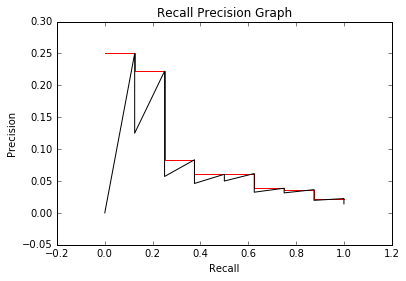

In [344]:
# Just for test, this is the interpolated plot before standardization
plotQuery(results, interpolated, "standard", 5)

---
### Part 3 Calculate the value at standard levels

## 3. Recall-Precision Graph

## 4. Average precision over all relevant documents (MAP)

In [ ]:
# Create array to store interpolated values
# at standard recall levels

recall = range(11)
recall = np.array(recall)/10.0
empty = np.zeros(recall.size)
tmp = np.array([recall, empty])
interpolated = pd.DataFrame(tmp.T, columns=["recall","precision"])
interpolated